In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
from configs.base_config import base_dir
from networks.models import SSuperVAE
from networks.pl_models.pl_ssupervae import SSuperVAE as PL_SSuperVAE
from torch.utils.data import DataLoader
import copy
from utils.image_utils import imshow
# import os
# import sys
# os.path.dirname(sys.executable)
# sys.path.append('/kuacc/users/baristopal20/SSuperGAN/')

In [58]:
from data.datasets.golden_panels import GoldenPanelsDataset
from utils.config_utils import read_config, Config
from utils.plot_utils import *
from utils import pytorch_util as ptu

In [59]:
config = read_config(Config.SSUPERVAE)
golden_age_config = read_config(Config.GOLDEN_AGE)
ptu.set_gpu_mode(True)

In [60]:
use_pl_model = True

In [73]:
if use_pl_model:
    checkpoint_location = base_dir + "playground/ssupervae/SSuperVAE23-06-2021-15-34-14/lightning_logs/version_2364871/checkpoints/epoch=62-step=72638.ckpt"
    model = PL_SSuperVAE.load_from_checkpoint(checkpoint_location)
    net = model.cuda().eval()
else:
    net = SSuperVAE(config.backbone,
                latent_dim=config.latent_dim,
                embed_dim=config.embed_dim,
                use_lstm=True,
                seq_size=config.seq_size,
                decoder_channels=config.decoder_channels,
                gen_img_size=config.image_dim,
                lstm_hidden=config.lstm_hidden,
                lstm_dropout=config.lstm_dropout,
                fc_hidden_dims=config.fc_hidden_dims,
                fc_dropout=config.fc_dropout,
                num_lstm_layers=config.num_lstm_layers,
                masked_first=config.masked_first).to(ptu.device)

    load_path = "checkpoints/lstm_ssupervae_model-checkpoint-epoch99.pth"
    net.load_state_dict(torch.load(load_path)['model_state_dict'])
    net = net.cuda().eval()

Loaded pretrained weights for efficientnet-b5


In [14]:
pnet = SSuperVAE(config.backbone, 
                latent_dim=config.latent_dim, 
                embed_dim=config.embed_dim,
                use_lstm=False,
                seq_size=config.seq_size,
                decoder_channels=config.decoder_channels,
                gen_img_size=config.image_dim,
                lstm_hidden=config.lstm_hidden,
                lstm_dropout=config.lstm_dropout,
                fc_hidden_dims=config.fc_hidden_dims,
                fc_dropout=config.fc_dropout,
                num_lstm_layers=config.num_lstm_layers,
                masked_first=config.masked_first).to(ptu.device) 

l_path = "/userfiles/comics_grp/pretrained_models/plain_ssupervae_epoch85.pth"
pnet.load_state_dict(torch.load(l_path)['model_state_dict'])
pnet = pnet.cuda().eval()

Loaded pretrained weights for efficientnet-b5


In [74]:
dataset = GoldenPanelsDataset(
        golden_age_config.panel_path,
        golden_age_config.sequence_path,
        config.panel_size,
        config.img_size,
        augment=False,
        mask_val=1,
        mask_all=False,
        return_mask=True,
        return_mask_coordinates=True,
        train_test_ratio=golden_age_config.train_test_ratio,
        train_mode=False,
        limit_size=-1)

dataset.data = [
     [['593/29_6.jpg', '593/30_0.jpg', '593/30_1.jpg'], [[[29, 0, 532, 503], [183, 51, 281, 149]], [[7, 0, 543, 536], [90, 229, 206, 345]], 
                                                         [[15, 0, 552, 537], [186, 192, 298, 304]]]], # animal
    
     [['3918/34_0.jpg', '3918/34_1.jpg', '3918/34_2.jpg'], [[[31, 0, 570, 539], [117, 278, 239, 400]], [[0, 14, 506, 520], [155, 181, 195, 221]],
                                                            [[18, 0, 514, 496], [121, 274, 229, 382]]]], # woman
    
     [['211/20_0.jpg', '211/20_1.jpg', '211/20_2.jpg'], [[[612, 0, 1165, 553], [1041, 188, 1105, 252]], [[20, 0, 589, 569], [386, 189, 462, 265]],
                                                        [[39, 0, 595, 556], [95, 175, 289, 369]]]], # bad man
    
     [['915/30_1.jpg', '915/30_2.jpg', '915/30_3.jpg'], [[[0, 7, 419, 426], [127, 205, 255, 333]], [[0, 59, 356, 415], [160, 258, 282, 380]],
                                                         [[0, 82, 264, 346], [89, 228, 193, 332]]]], # good man

     [['3513/21_5.jpg', '3513/21_6.jpg', '3513/22_0.jpg'], [[[59, 0, 611, 552], [199, 180, 369, 350]], [[0, 17, 533, 550], [90, 206, 164, 280]],
                                                            [[0, 69, 395, 464], [73, 230, 185, 342]]]], # good man

     [['2464/73_4.jpg', '2464/73_5.jpg', '2464/73_6.jpg'], [[[131, 0, 743, 612], [225, 206, 361, 342]], [[168, 0, 890, 722], [602, 316, 658, 372]],
                                                            [[73, 0, 740, 667], [185, 266, 331, 412]]]], # mask problem
 ]

data_loader = DataLoader(dataset, batch_size=1)

In [75]:
dl_iter = iter(data_loader)

## Model Result Test

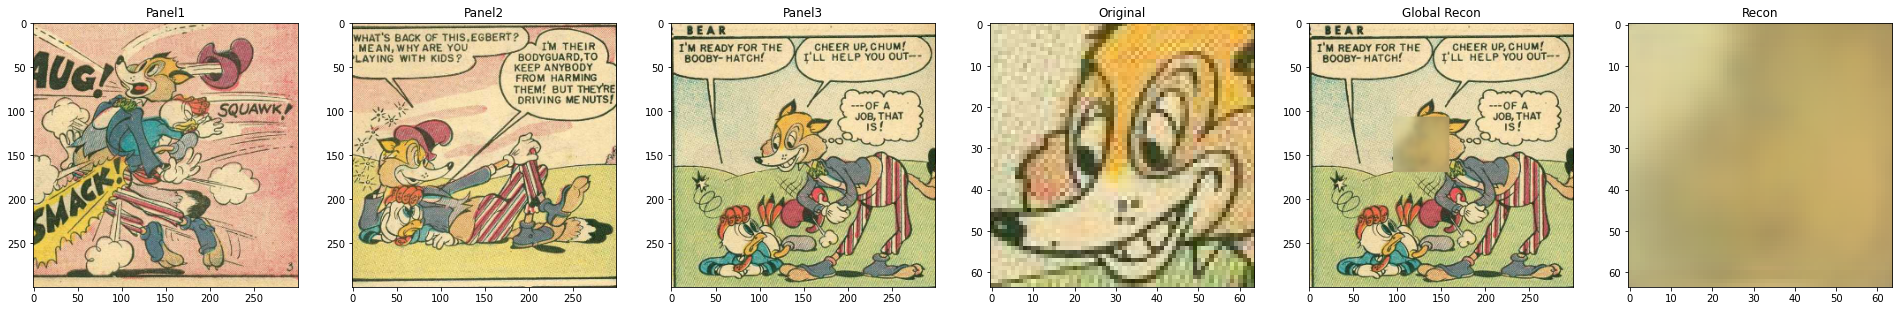

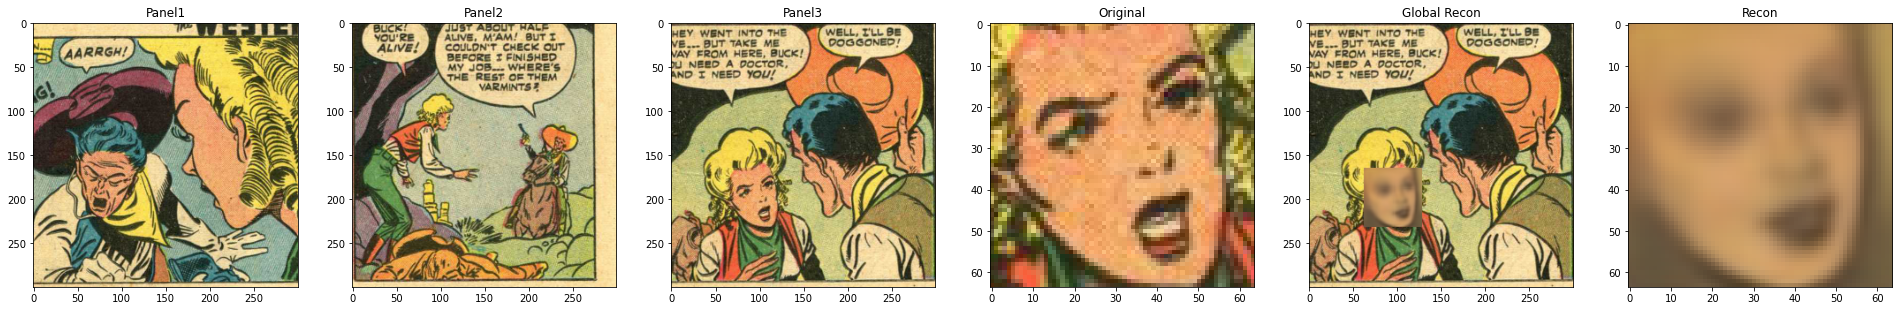

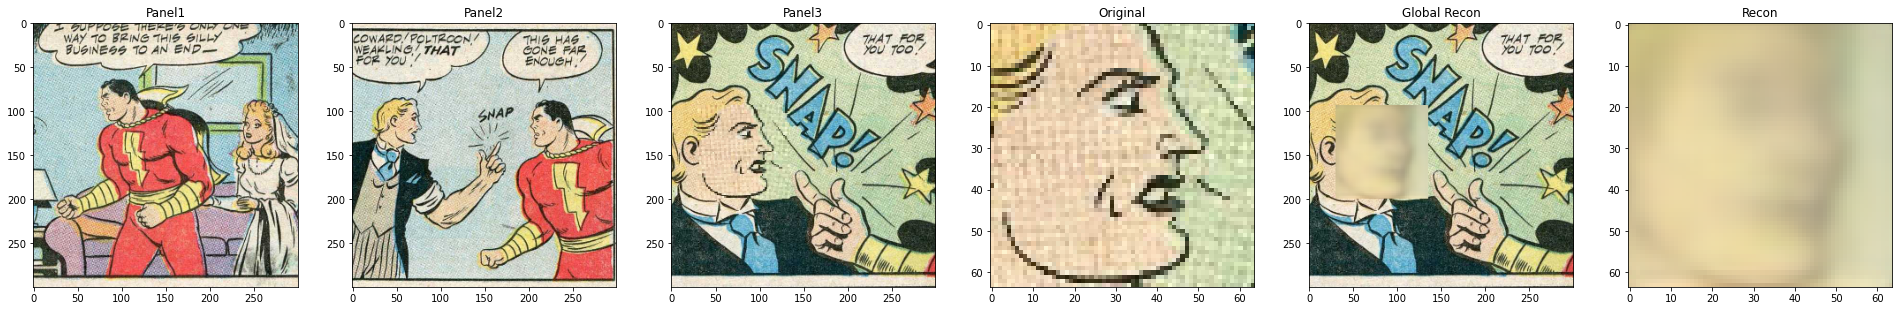

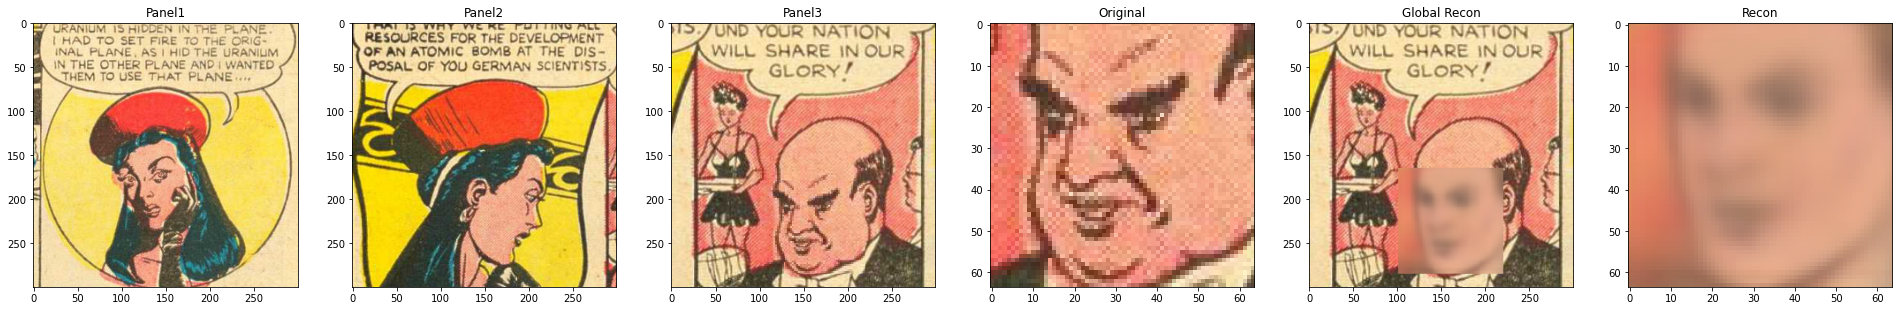

In [ ]:
ctr, limit = 0, 6
for x, y, mask, coord in dl_iter:

    with torch.no_grad():
        # for seq_size = 1
        # mu_z, logstd_z = net(torch.unsqueeze(x[0:1, -1], 0).cuda(), f='seq_encode')
        # for seq_size = 3
        mu_z, logstd_z = net(x.cuda(), f='seq_encode')
        # z = net.reparameterize((mu_z, logstd_z))
        z = mu_z.unsqueeze(-1).unsqueeze(-1)
        y_recon = net(z, f='generate')
        recon_global, gt_global = net.create_global_images(copy.deepcopy(x), y, y_recon, coord)
        plot_panels_and_faces(torch.cat([x[:,:2,:,:,:], gt_global.cpu().unsqueeze(1)], dim=1), y, y_recon, recon_global)
        
#     if config.use_lstm and not config.lstm_conv:
#         net.module.seq_encoder.lstm.train()
        
#     draw_saliency(net, x, y)
        
#     if config.use_lstm and not config.lstm_conv:
#         net.module.seq_encoder.lstm.eval()
    
    ctr += 1
    if ctr == limit:
        break

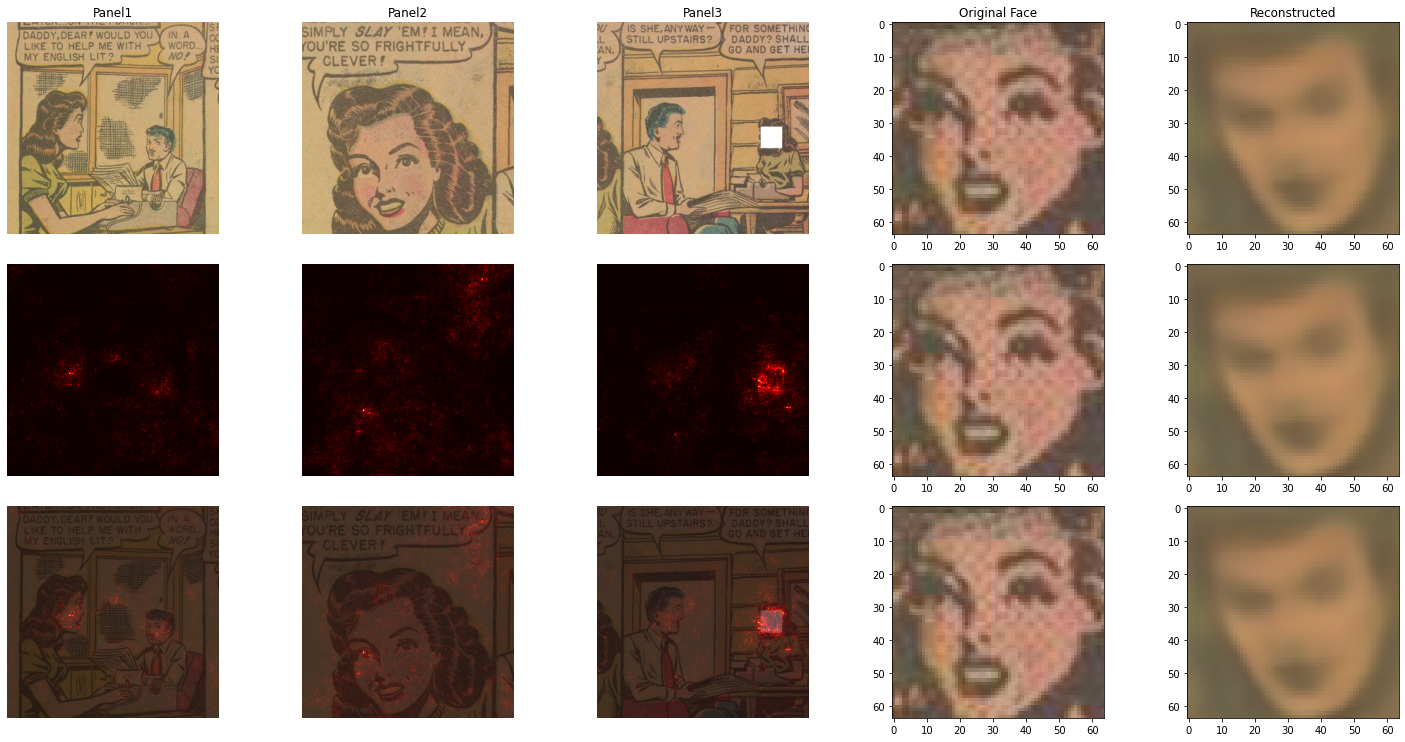

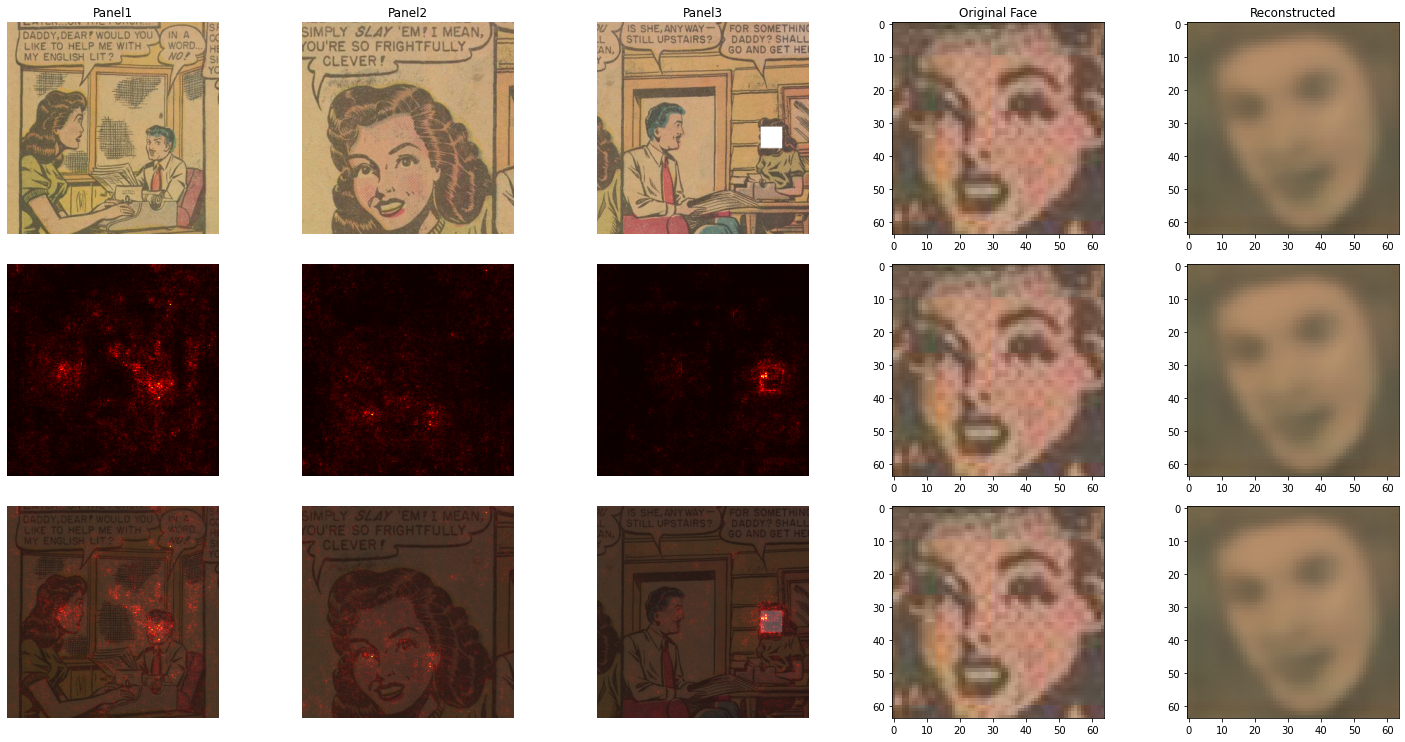

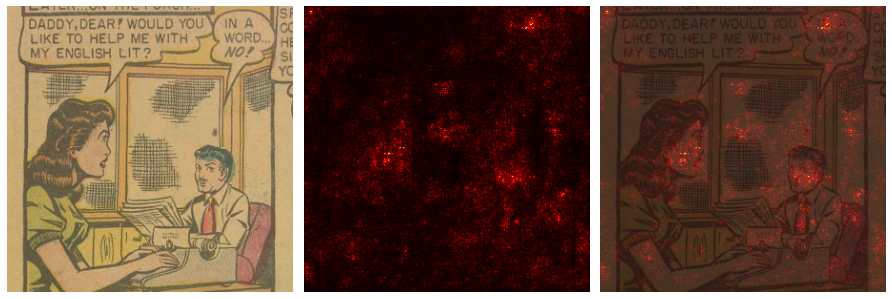

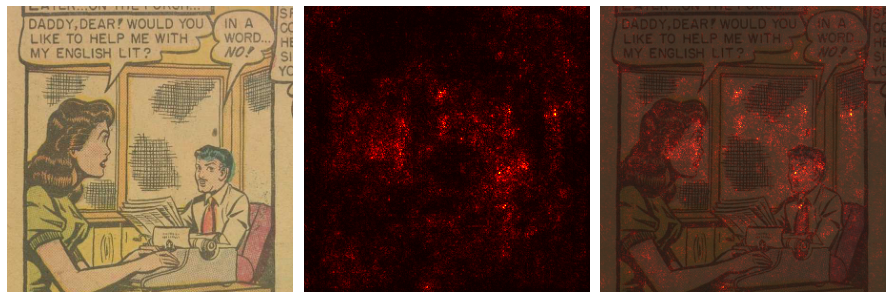

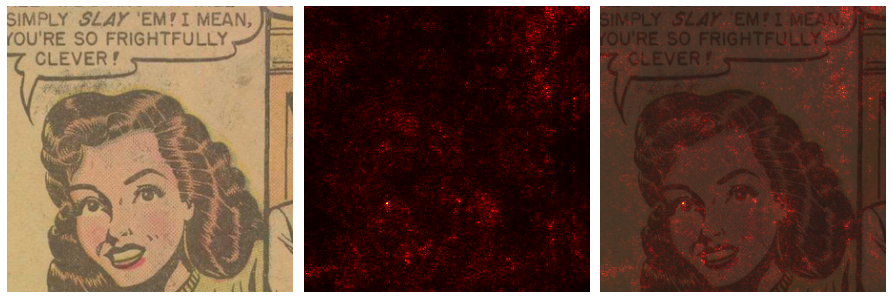

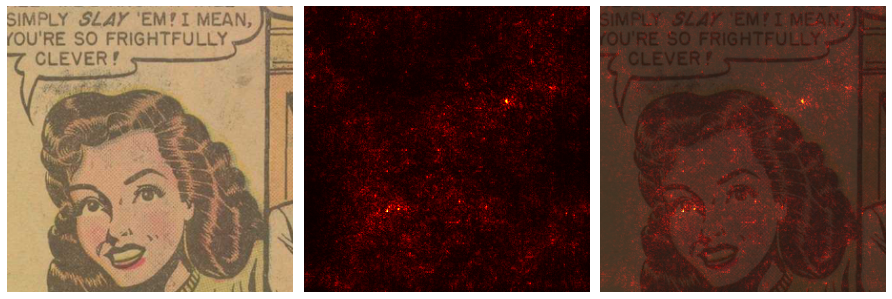

LSTM(256, 256)

In [11]:
import copy

net.encoder.lstm.train()

x, y, z = next(dl_iter)

draw_saliency(net, copy.deepcopy(x), copy.deepcopy(y))
draw_saliency(pnet, copy.deepcopy(x), copy.deepcopy(y))

draw_backbone_saliency(net.encoder.embedder, copy.deepcopy(x), 0)
draw_backbone_saliency(pnet.encoder.embedder, copy.deepcopy(x), 0)

draw_backbone_saliency(net.encoder.embedder, copy.deepcopy(x), 1)
draw_backbone_saliency(pnet.encoder.embedder, copy.deepcopy(x), 1)

net.encoder.lstm.eval()

In [7]:
import torch
import torch.nn.functional as F

def kl_loss_old(z, mu, std):
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)
    log_q = q.log_prob(z)
    log_p = p.log_prob(z)
    return F.kl_div(log_p, log_q, reduction="batchmean", log_target=True)


def kl_loss_new(z, mu, std):
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)

    kl_dvergence = torch.distributions.kl.kl_divergence(q,p)
    kl_loss = kl_dvergence.sum(1).mean()
    return kl_loss

In [8]:
z = torch.randn(1, 256)
mu = torch.randn(1, 256)
std = torch.randn(1, 256).exp()

print(kl_loss_old(z, mu, std))
print(kl_loss_new(z, mu, std))

tensor(15.4770)
tensor(1199.8945)
